In [12]:
import fastai
import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.data.all import *
import matplotlib.pyplot as plt
from PIL import ImageFilter, ImageOps

# Sampling

## Preparation

### Read in metadata.

In [13]:
csv_path = "../archive/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


### Translate shortcuts

In [14]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer 
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps 
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}

### Let's create a dictionary, mapping each image id to a disease.

In [15]:
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] # returns only dx and image id column
img_to_class_dict = img_to_class_dict.to_dict('list')  # returns columns as lists in a dict
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } # returns a dict mapping image id to disease name
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [16]:
def get_label_from_dict(path):
    """return the label from dict"""
    return img_to_class_dict[path.stem] # path.stem returns the filename without suffix

def get_label_from_dx(disease):
    """return the label from dict"""
    return short_to_full_name_dict.get(disease) # path.stem returns the filename without suffix


In [17]:
skin_df["label"] = skin_df["dx"].apply(get_label_from_dx)
skin_df = skin_df.loc[:, ["image_id", "dx", "label"]]
skin_df.head()

,image_id,dx,label
0,ISIC_0027419,bkl,benign keratosis-like lesions
1,ISIC_0025030,bkl,benign keratosis-like lesions
2,ISIC_0026769,bkl,benign keratosis-like lesions
3,ISIC_0025661,bkl,benign keratosis-like lesions
4,ISIC_0031633,bkl,benign keratosis-like lesions


In [18]:
skin_df["label"].value_counts()

melanocytic nevi                 6705
melanoma                         1113
benign keratosis-like lesions    1099
basal cell carcinoma              514
Bowen's disease                   327
vascular lesions                  142
dermatofibroma                    115
Name: label, dtype: int64

Die Klassen in diesem Dataset sind sehr ungleich verteilt. Die häufigste Klasse (melanocytic nevi) hat einen Anteil von 67%, wohingegen die seltenste Klasse (dermatofibroma) einen Anteil von 1% hat. Dies ist im nachfolgenden Histogramm zu sehen.

<AxesSubplot:>

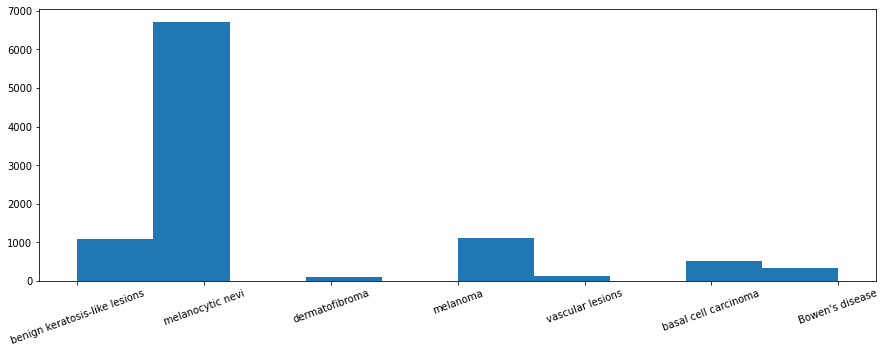

In [19]:
skin_df["label"].hist(figsize=(15,5),xrot=20,grid=False)

In [20]:
# split dataframe into train, valid and test sets

msk = np.random.rand(len(skin_df)) < 0.7
train_df = skin_df[msk]

valid_df = skin_df[~msk]
len(train_df)

6985

In [21]:
print(f"validation set: {len(valid_df)/(len(train_df)+len(valid_df)):.2f}% train set: {len(train_df)/(len(train_df)+len(valid_df)):.2f}%")

validation set: 0.30% train set: 0.70%


## Sampling

In [22]:
max(train_df["label"].value_counts().items(),key=lambda x:x[1])

('melanocytic nevi', 4664)

In [23]:
class Resampling:
    """
    class for sampling the trainings dataframe
    > oversampling: copy all classes to the same sample size as strongest class
    > undersampling: take from each class as many samples as the weakest class has
    > median sampling: take the mean size of samples per class and take that many samples from each class
    """
    def __init__(self,train_df,image_path = "/Users/macbook/projects/project/archive/HAM10000_images"):
        self.train_df = train_df
        self.image_path = image_path
        
    def get_oversampled_df(self)->pd.DataFrame:
        """ copy all classes to the same sample size as strongest class"""
        max_name, max_size = max(self.train_df["label"].value_counts().items(),key=lambda x:x[1])
        print("max size:",max_size)
        new_df = pd.DataFrame()
        for label in self.train_df.label.unique():
            if label != max_name:
                label_df = train_df[train_df.label == label]
                label_df = label_df.sample(max_size, replace=True)
                new_df = pd.concat([new_df,label_df],axis=0)
        return new_df

    def get_undersampled_df(self)->pd.DataFrame:
        """ take from each class as many samples as the weakest class has"""
        min_name, min_size = min(self.train_df["label"].value_counts().items(),key=lambda x:x[1])
        print("min size:",min_size)
        new_df = pd.DataFrame()
        for label in self.train_df.label.unique():
            if label != min_name:
                label_df = train_df[train_df.label == label]
                print("initial len",len(label_df))
                label_df = label_df.sample(n=min_size, replace=False)
                print("reduced len",len(label_df))
                new_df = pd.concat([new_df,label_df],axis=0)
        return new_df

    def get_median_sampled_df(self)->pd.DataFrame:
        """ take the mean size of samples per class and take that many samples from each class"""
        mean_size = np.mean(self.train_df["label"].value_counts().values)
        print("mean size:",mean_size)
        new_df = pd.DataFrame()
        for label in self.train_df.label.unique():
            label_df = train_df[train_df.label == label]
            label_df = label_df.sample(int(mean_size), replace=True)
            new_df = pd.concat([new_df,label_df],axis=0)
        return new_df
    
    def get_downsampled_df(self,factor:float)->pd.DataFrame:
        """ returns a downsampled dataframe, 
        with smaller classes copied factor-times
        from the original dataframe
        """
        new_df = pd.DataFrame()
        max_name, _ = max(self.train_df["label"].value_counts().items(),key=lambda x:x[1])
        for label in self.train_df.label.unique():
            if label == max_name: # skip the biggest class
                continue
            label_df = train_df[train_df.label == label]
            label_df = label_df.sample(n=int(len(label_df)*factor), replace=False)
            new_df = pd.concat([new_df,label_df],axis=0)
        return new_df
    
    def custom_sampling(self, weak_count:int=500):
        """ this iterates over all photos and saves the weaker classes as copys in grey"""
        
        # list copy directory
        if os.listdir(os.path.join(self.image_path,"copy")) != []:
            raise Exception("copy directory is not empty")
        
        # save weak classes as r,g,b, unsharp and blurred
        custom_sampled_df = pd.DataFrame(columns=self.train_df.columns) # optional: train_df.copy()
        cols = self.get_keys_from_values_below(self.train_df.label.value_counts(),weak_count)
        file_list = self.train_df['image_id'].loc[train_df.label.isin(cols)].tolist()
        for count in range(0,2):
            for id in file_list:
                image_file = os.path.join(self.image_path, id + ".jpg")
                os.chdir(self.image_path)
                im=Image.open(image_file)
                im=im.convert("RGB")
                r,g,b=im.split()
                r=r.convert("RGB")
                g=g.convert("RGB")
                b=b.convert("RGB")
                im_blur=im.filter(ImageFilter.GaussianBlur)
                im_unsharp=im.filter(ImageFilter.UnsharpMask)
                os.chdir(os.path.join(self.image_path, "copy"))
                r.save(str(count)+'r_'+id+".jpg")
                g.save(str(count)+'g_'+id+".jpg")
                b.save(str(count)+'b_'+id+".jpg")
                im_blur.save(str(count)+'bl_'+id+".jpg")
                im_unsharp.save(str(count)+'un_'+id+".jpg")
                for name in ["r","g","b","bl","un"]:
                    format = lambda x: f"{count}_{name}_{x}"
                    custom_rows = train_df.loc[train_df["image_id"] == id]
                    custom_rows["image_id"] = custom_rows.loc["image_id"].apply(format)
                    custom_sampled_df = pd.concat([custom_sampled_df,custom_rows],axis=0)
        
        # save images from the strong classes as greyscale also in copy directory
        other_cols = [col for col in self.train_df.columns if col not in cols]
        file_list = self.train_df['image_id'].loc[train_df.label.isin(other_cols)].tolist()
        for id in file_list:
            image_file = os.path.join(self.image_path, id + ".jpg")
            os.chdir(self.image_path)
            im=Image.open(image_file)
            im=ImageOps.grayscale(im)
            os.chdir(os.path.join(self.image_path, "copy"))
            im.save(str(0)+'n_'+id+".jpg")
            format = lambda x: f"{count}_{name}_{x}"
            custom_rows = train_df.loc[train_df["image_id"] == id]
            custom_rows["image_id"] = custom_rows.loc["image_id"].apply(format)
            custom_sampled_df = pd.concat([custom_sampled_df,custom_rows],axis=0)
        
        return custom_sampled_df
                
    @staticmethod
    def get_keys_from_values_below(dictionary, value):
        """return the key from dict"""
        return [k for k, v in dictionary.items() if v <= value]

    

In [25]:
sampler = Resampling(train_df)
undersampled_df = sampler.get_undersampled_df()
oversampled_df = sampler.get_oversampled_df()
median_df = sampler.get_median_sampled_df()
custom_df = sampler.custom_sampling(weak_count=500)

custom_df.to_csv("../sampling/custom_df.csv",index=False)
median_df.to_csv("../sampling/median_df.csv",index=False)
oversampled_df.to_csv("../sampling/oversampled_df.csv",index=False)
undersampled_df.to_csv("../sampling/undersampled_df.csv",index=False)

custom_df = pd.read_csv("../sampling/custom_df_500.csv")
median_df = pd.read_csv("../sampling/median_df.csv")
oversampled_df = pd.read_csv("../sampling/oversampled_df.csv")
undersampled_df = pd.read_csv("../sampling/undersampled_df.csv")


In [26]:
custom_df.label.value_counts()

basal cell carcinoma    3560
Bowen's disease         2290
vascular lesions         890
dermatofibroma           690
Name: label, dtype: int64

In [27]:
len(os.listdir(os.path.join("../archive/HAM10000_images","copy")))

7430

In [28]:
train_df["image_id"].loc[train_df["image_id"] == id].apply(format)

Series([], Name: image_id, dtype: object)

In [29]:
custom_df.head()


,image_id,dx,label
0,0_r_ISIC_0027008,df,dermatofibroma
1,0_g_ISIC_0027008,df,dermatofibroma
2,0_b_ISIC_0027008,df,dermatofibroma
3,0_bl_ISIC_0027008,df,dermatofibroma
4,0_un_ISIC_0027008,df,dermatofibroma


In [30]:
undersampled_df.label.value_counts(),oversampled_df.label.value_counts(),median_df.label.value_counts()

(benign keratosis-like lesions    82
 melanocytic nevi                 82
 melanoma                         82
 vascular lesions                 82
 basal cell carcinoma             82
 Bowen's disease                  82
 Name: label, dtype: int64,
 benign keratosis-like lesions    4691
 dermatofibroma                   4691
 melanoma                         4691
 vascular lesions                 4691
 basal cell carcinoma             4691
 Bowen's disease                  4691
 Name: label, dtype: int64,
 benign keratosis-like lesions    999
 melanocytic nevi                 999
 dermatofibroma                   999
 melanoma                         999
 vascular lesions                 999
 basal cell carcinoma             999
 Bowen's disease                  999
 Name: label, dtype: int64)

Text(0.5, 1.0, 'median')

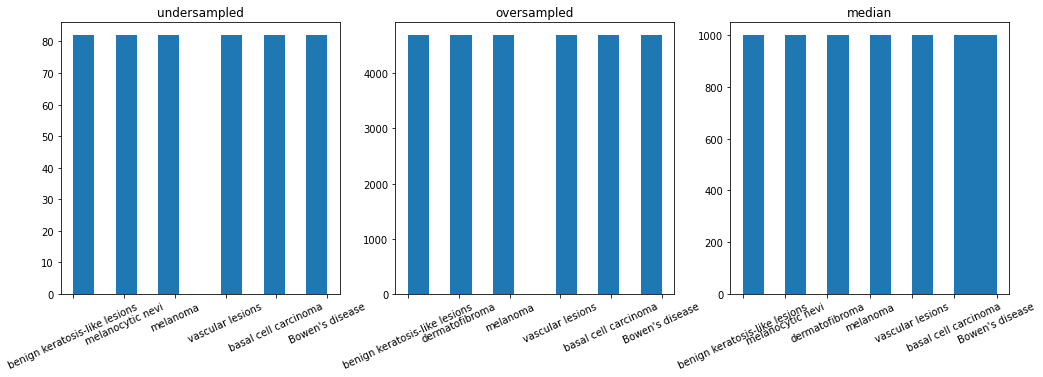

In [31]:
fig,ax = plt.subplots(1,3,figsize=(17,5))
#show histogramms for each dataframe
undersampled_df["label"].hist(ax=ax[0],bins=12,grid=False,xrot=25)
ax[0].set_title("undersampled")
oversampled_df["label"].hist(ax=ax[1],bins=12,grid=False,xrot=25)
ax[1].set_title("oversampled")
median_df["label"].hist(ax=ax[2],bins=12,grid=False,xrot=25)
ax[2].set_title("median")

In [32]:
skin_df.head()

,image_id,dx,label
0,ISIC_0027419,bkl,benign keratosis-like lesions
1,ISIC_0025030,bkl,benign keratosis-like lesions
2,ISIC_0026769,bkl,benign keratosis-like lesions
3,ISIC_0025661,bkl,benign keratosis-like lesions
4,ISIC_0031633,bkl,benign keratosis-like lesions


## Training

In [33]:

dls = ImageDataLoaders.from_df(skin_df, 
                            path="../archive/HAM10000_images", 
                            valid_pct=0.3, 
                            seed=42, 
                            f_col=0, 
                            suff='.jpg', 
                            label_col=1, 
                            item_tfms=[Resize(450), DihedralItem()], 
                            batch_tfms=RandomResizedCrop(size=224, min_scale=0.75), 
                            bs=64, 
                            val_bs=None, 
                            device=None)

### Display some images with labels

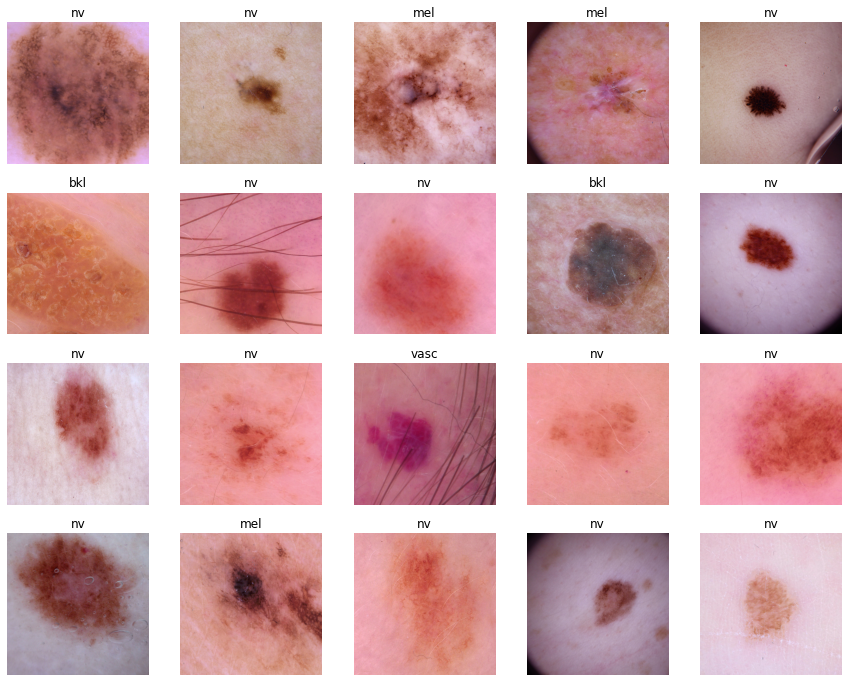

In [34]:
dls.show_batch(max_n=20, nrows=4) # show a batch of images with labels

## Model

### Create learner with ResNet18 (pretrained), and specify optimizer as ranger.
### Transfer learning with Mix up for 30 epochs.

Mix up is a data augmentation technique that allows the combination of two classes per image.
This is used to stop overfitting, because this is a very small dataset.

In [ ]:
for dataframe in [custom_df,median_df,oversampled_df,undersampled_df]:
    #create a dataloader
    name = dataframe.name
    print("name:",name)
    dls = ImageDataLoaders.from_df(skin_df, 
                            path="../archive/HAM10000_images", 
                            valid_pct=0.3, 
                            seed=42, 
                            f_col=0, 
                            suff='.jpg', 
                            label_col=1, 
                            item_tfms=[Resize(450), DihedralItem()], 
                            batch_tfms=RandomResizedCrop(size=224, min_scale=0.75), 
                            bs=64, 
                            val_bs=None, 
                            device=None)
    
    learn = cnn_learner(dls, resnet18, metrics=accuracy, opt_func=ranger)
    lrs = learn.lr_find()
    lr = (lrs[0] + lrs[1])/2 #mittelwert der learning rates
    print("suggested learning_rate:",lrs, "using:",lr)
    learn.fine_tune(epochs=30, freeze_epochs=3, base_lr=lr, cbs=MixUp(0.5)) # use mixup with callbacks
    learn.export(f"Samling_{name}_training_30_epochs")

# Metrics

In [41]:
from fastai.metrics import *
metrics = []

['BaseLoss', 'CrossEntropyLossFlat', 'BCEWithLogitsLossFlat', 'BCELossFlat', 'MSELossFlat', 'L1LossFlat', 'LabelSmoothingCrossEntropy', 'LabelSmoothingCrossEntropyFlat']


Im folgenden sollen verschiedene Metriken definiert werden, welche in einem Abschließenden Training vergleichen werden sollen.

#### Average Precision

In [ ]:
metrics.append({"APScoreMulti":APScoreMulti})

#### MatthewsCorrCoefMulti

In [ ]:
metrics.append({"MatthewsCorrCoefMulti":MatthewsCorrCoefMulti})

#### FBeta Score

In [ ]:
metrics.append({"FBetaMulti":FBetaMulti})

#### Brier Score:

In [ ]:
metrics.append({"BrierScoreMulti":BrierScoreMulti})

#### F1 Score

In [ ]:
metrics.append({"F1ScoreMulti":F1ScoreMulti})

#### Jaccard Score

In [ ]:
metrics.append({"JaccardMulti":JaccardMulti})

#### ROC AUC

In [ ]:
metrics.append({"RocAucMulti":RocAucMulti})

#### Accuracy (Baseline)

In [ ]:
metrics.append({"accuracy":accuracy_multi})

In [ ]:
for elem in metrics:
    name = elem[0]
    print("Metric:",name)
    metric = elem[1]
    learn = cnn_learner(dls, resnet18, metrics=metric, opt_func=ranger)
    lrs = learn.lr_find()
    lr = (lrs[0] + lrs[1])/2 #mittelwert der learning rates
    print("suggested learning_rate:",lrs, "using:",lr)
    learn.fine_tune(epochs=30, freeze_epochs=3, base_lr=lr, cbs=MixUp(0.5)) # use mixup with callbacks
    learn.export(f"Metrics_{name}_training_30_epochs")

## Loss Functions

In [38]:
from fastai.losses import *
losses = []

Cross Entropy Loss

In [39]:
losses.append({"CrossEntropyLossFlat":CrossEntropyLossFlat()})

BCE with Logits Loss flat(BCE,MSE,L1)


In [ ]:
losses.append({"BCEWithLogitsLossFlat":BCEWithLogitsLossFlat()})
losses.append({"BCELossFlat":BCELossFlat()})
losses.append({"MSEWithLogitsLossFlat":MSELossFlat()})
losses.append({"BCEWithLogitsLossFlat":L1LossFlat()})

Label smoothing Cross Entropy (Flat)

In [ ]:
losses.append({"LabelSmoothingCrossEntropy":LabelSmoothingCrossEntropy()})
losses.append({"LabelSmoothingCrossEntropy":LabelSmoothingCrossEntropyFlat()})

Focal Loss

In [ ]:


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

losses.append({"FocalLoss_gamma1":FocalLoss(gamma=1)})
losses.append({"FocalLoss_gamma2":FocalLoss(gamma=2)})

In [ ]:
for loss in losses:
    name = loss[0]
    print("Loss:",name)
    loss_class = loss[1]
    
    learn = cnn_learner(dls,  resnet18, loss_func=loss_class, metrics=accuracy, opt_func=ranger)
    lrs = learn.lr_find()
    lr = (lrs[0] + lrs[1])/2 
    print("suggested learning_rate:",lrs, "using:",lr)
    learn.fine_tune(epochs=30, freeze_epochs=3, base_lr=lr, cbs=MixUp(0.5)) # use mixup with callbacks
    learn.export(f"Losses_{name}_training_30_epochs")

###